# DD2437 Lab 3, Hopfield networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data
x1 = np.array([-1, -1, 1, -1, 1, -1, -1, 1])
x2 = np.array([-1, -1, -1, -1, -1, 1, -1, -1])
x3 = np.array([-1, 1, 1, -1, -1, 1, -1, 1])

In [3]:
def sign(x):
    return np.where(x < 0, -1, 1)

In [4]:
def calc_weights(pattern, normalize=False):
    if normalize:
        return pattern.T.dot(pattern)/pattern.shape[1]
    return pattern.T.dot(pattern)

In [85]:
def update_rule(pattern, weights):
    return sign(np.dot(pattern, weights))

In [6]:
pattern = np.c_[x1, x2, x3].T
weights = calc_weights(pattern)
(update_rule(pattern, weights) == pattern).all()

True

Make sure that the above says true, this means we've initialized the hopfield network to maintain our x-input as fixed points. Not modifying them in the update step.

## 3.1 Convergence and attractors

In [7]:
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1])
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1])
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1])
patterns_mod = np.c_[x1d, x2d, x3d].T

In [8]:
def update_til_converge(pattern, weights, return_iterations=False):
    updated = pattern
    prev = np.zeros(pattern.shape)
    iterations = 0
    while not (updated == prev).all():
        prev = updated
        updated = update_rule(prev, weights)
        iterations += 1

    if return_iterations:
        return updated, iterations
    
    return updated

In [9]:
updated = update_til_converge(patterns_mod, weights)

In [10]:
updated == pattern

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

x2d does not converge to the stored pattern, the other two do however.

In [11]:
def examine_states(weights):
    N = weights.shape[0]
    attractors = []
    for val in range(2**N):
        bin_val = format(val, '0{}b'.format(N))
        bin_list = np.array([int(b) for b in bin_val])
        input_val = np.where(bin_list == 1, 1, -1)
        attractors.append(update_til_converge(input_val, weights))
    return attractors

In [12]:
attractors = examine_states(weights)
attractors = [tuple(attractor) for attractor in attractors]

In [13]:
from collections import Counter
import operator

counts = dict(Counter(attractors))
# counts = sorted(counts.items(), key=operator.itemgetter(1))
# print(counts, len(counts))
for key, count in counts.items():
    if (np.array(key) == x1).all():
        print("x1: {}".format(count))
    elif (np.array(key) == x2).all():
        print("x2: {}".format(count))
    elif (np.array(key) == x3).all():
        print("x3: {}".format(count))
    else:
        print(key, count)

x2: 20
(-1, -1, 1, -1, -1, 1, -1, 1) 7
(-1, -1, 1, -1, 1, 1, -1, 1) 15
(-1, -1, -1, -1, 1, -1, -1, -1) 1
x1: 20
(1, -1, -1, 1, 1, -1, 1, -1) 32
(1, 1, -1, 1, -1, 1, 1, -1) 36
(1, 1, 1, 1, 1, -1, 1, 1) 57
x3: 42
(-1, 1, -1, -1, -1, 1, -1, -1) 4
(1, 1, -1, 1, 1, -1, 1, -1) 12
(-1, 1, 1, -1, 1, -1, -1, 1) 4
(1, 1, 1, 1, -1, 1, 1, 1) 4
(1, 1, -1, 1, 1, 1, 1, -1) 2


In [14]:
def examine_distant_states(weights):
    N = weights.shape[0]
    convergence_times = {}
    for val in range(2**N):
        bin_val = format(val, '0{}b'.format(N))
        bin_list = np.array([int(b) for b in bin_val])
        input_val = np.where(bin_list == 1, 1, -1)
        val, iterations = update_til_converge(input_val, weights, return_iterations=True)
        convergence_times[bin_val] = iterations
    return convergence_times

In [15]:
def get_min_dist(bin_val, baselines):
    bin_list = np.array([int(b) for b in bin_val])
    pattern = np.where(bin_list == 1, 1, -1)
    min_dist = pattern.shape[0]
    
    for baseline in baselines:
        min_dist = min(min_dist, list(pattern == baseline).count(False))
    return min_dist

In [22]:
convergence_times = examine_distant_states(weights)
for val, iterations in convergence_times.items():
    min_dist = get_min_dist(val, [x1, x2, x3])
    if min_dist >= x1.shape[0]/2:
        pass
#         print(min_dist, iterations)

1. Did all the patterns converge towards stored patterns?

*They converge, but x2d does not converge to x2 (nor x1, x3)*

2. How many attractors are there in this network? Hint: automate the searching.

*14 in total, see In: 13*

3. What happens when you make the starting pattern even more dissimilar to the stored ones (e.g. more than half is wrong)?

*The pattern converges to a different attractor.*

## 3.2 Sequential Update

In [17]:
def get_pict_data():
    filename = "pict.dat"
    pictsdata = []
    with open(filename) as f:
        pictsdata = [int(p_val) for p_val in f.read().split(',')]
    return pictsdata

In [46]:
PICT_DIM = 1024
picts_raw = get_pict_data()
NO_PICTS = int(len(picts_raw)/PICT_DIM)
IMG_DIMS = (32, 32)

picts = []
for ndx in range(NO_PICTS):
    picts.append(picts_raw[PICT_DIM*ndx : PICT_DIM*(ndx+1)])

In [47]:
def print_image(image, dims):
    imagedata = np.where(image == 1, 1, 0).reshape(dims)
    plt.imshow(imagedata)

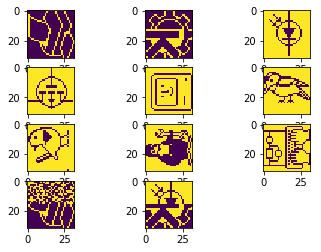

In [48]:
# Print the data
fig = plt.figure()
for ndx, pict in enumerate(picts):
    fig.add_subplot(4, 3, ndx+1)
    print_image(np.array(pict), IMG_DIMS)

In [73]:
p1 = np.array(picts[0])
p2 = np.array(picts[1])
p3 = np.array(picts[2])
p4 = np.array(picts[3])
p5 = np.array(picts[4])
p6 = np.array(picts[5])
p7 = np.array(picts[6])
p8 = np.array(picts[7])
p9 = np.array(picts[8])
p10 = np.array(picts[9])
p11 = np.array(picts[10])

pattern = np.c_[p1, p2, p3].T
weights = calc_weights(pattern)

**Check that the three patterns are stable:**

In [74]:
updated, iterations = update_til_converge(
    pattern, weights, return_iterations=True)

print("Network converged to pattern={} after {} iteration(s)".format(
    (updated == pattern).all(), iterations))

Network converged to pattern=True after 1 iteration(s)


**Can the network complete a degraded pattern?**

p10 converged to p1=True after 2 iteration(s)


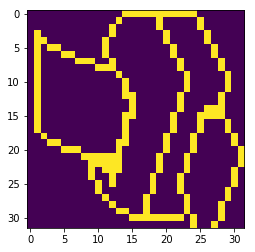

In [75]:
updated, iterations = update_til_converge(p10, weights, True)
print("p10 converged to p1={} after {} iteration(s)".format(
    (updated == p1).all(), iterations))

print_image(updated, IMG_DIMS)

p11 converged=False after 3 iteration(s)


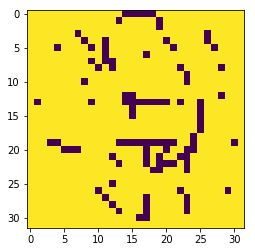

In [76]:
updated, iterations = update_til_converge(p11, weights, True)
print("p11 converged={} after {} iteration(s)".format(
    (updated == p2).all(), iterations))

print_image(updated, IMG_DIMS)

**Clearly convergence is practically instantaneous. What happens if we select units randomly?**

In [86]:
from random import randrange

def random_update_til_converge(pattern, weights, 
                               return_iterations=False,
                               print_image=None):
    updated = pattern
    prev = np.zeros(pattern.shape)
    iterations = 0
    fig = plt.figure()
    for ndx in range(print_image*3):
        prev = updated
        
        random_i = randrange(weights.shape[0])
        updated[random_i] = update_rule(prev, weights[random_i,:])
        
        iterations += 1
        
        if ndx % print_image == 0:
            fig.add_subplot(3, 1, int(ndx/print_image)+1)
            print_image(updated, IMG_DIMS)

    if return_iterations:
        return updated, iterations
    
    return updated

TypeError: 'int' object is not callable

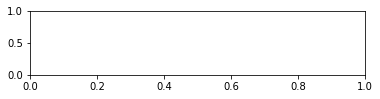

In [87]:
random_update_til_converge(p10, weights, False, 100)

array([1, 2, 3, 4, 5])